# Demo register image on differents pretrained model and visualize output 

In [1]:
# File paths to the moving and fixed images
moving_image_file = r'D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0451_MR1/slice_norm.nii.gz'
fixed_image_file  = r'D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0447_MR1/slice_norm.nii.gz'

In [2]:
# File paths to the moving and fixed segmentation 
moving_seg_file = r"D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0451_MR1/slice_seg4.nii.gz"
fixed_seg_file  = r"D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0447_MR1/slice_seg4.nii.gz"

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import neurite as ne 
import voxelmorph as vxm
import tensorflow as tf

In [4]:
def warp_segmentation(moving_seg_file, warp_file, output_file, device="/CPU:0"):
    """
    Áp dụng warp (deformation field) lên segmentation và lưu kết quả ra file.

    Parameters
    ----------
    moving_seg_file : str
        Đường dẫn tới file NIfTI của moving segmentation.
    warp_file : str
        Đường dẫn tới file NIfTI warp (deformation field).
    output_file : str
        Đường dẫn lưu file warped segmentation NIfTI.
    device : str, optional
        Thiết bị TensorFlow để chạy, mặc định "/CPU:0".
    """
    # Load moving segmentation
    moving_seg = vxm.py.utils.load_volfile(
        moving_seg_file, add_batch_axis=True, add_feat_axis=True
    )

    # Load warp (deformation field)
    warp, warp_affine = vxm.py.utils.load_volfile(
        warp_file, add_batch_axis=True, ret_affine=True
    )

    # Build transform model (use nearest neighbor for segmentation)
    transform_model = vxm.networks.Transform(moving_seg.shape[1:-1], interp_method='nearest')

    # Apply warp
    with tf.device(device):
        warped_seg = transform_model.predict([moving_seg, warp])

    # Remove batch dimension but giữ lại channel (=> shape: [H, W, 1])
    warped_seg = np.squeeze(warped_seg, axis=0)

    # Save warped segmentation
    vxm.py.utils.save_volfile(warped_seg, output_file, warp_affine)
    print(f"Warped segmentation saved to: {output_file}  (shape: {warped_seg.shape})")
    
    return warped_seg

In [5]:
def summarize_nifti(file_path):
    """
    Hàm in thông tin tổng quan của một file NIfTI (.nii hoặc .nii.gz)

    Args:
        file_path (str): Đường dẫn tới file NIfTI
    """
    try:
        img = nib.load(file_path)
        data = img.get_fdata()
        header = img.header

        print(f"--- File: {file_path} ---")
        print("Shape:", data.shape)
        print("Data type:", data.dtype)
        print("Voxel size (mm):", header.get_zooms())
        print("Min value:", np.min(data))
        print("Max value:", np.max(data))
        print("Mean value:", np.mean(data))
        print("\n")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")


In [6]:
def load_nii(path):
    """Load NIfTI file và trả về mảng numpy"""
    return nib.load(path).get_fdata()

def rotate_img(img, k=-1):
    """Xoay ảnh 2D hoặc từng kênh của ảnh 3D - mặc định xoay -90 độ"""
    return np.rot90(img, k=k)

def visualize_registration(moving_file, fixed_file, moved_file,
                           moving_seg_file=None, fixed_seg_file=None,
                           moved_seg_file=None, flow_file=None):
    """
    Load images, xoay, load deformation field và hiển thị các kết quả.
    """
    # Load và xoay ảnh
    moving = rotate_img(load_nii(moving_file)[:,:,0])
    fixed  = rotate_img(load_nii(fixed_file)[:,:,0])
    moved  = rotate_img(load_nii(moved_file)[:,:])

    # Load segmentation nếu có
    moving_seg = rotate_img(load_nii(moving_seg_file)[:,:,0]) if moving_seg_file else None
    fixed_seg  = rotate_img(load_nii(fixed_seg_file)[:,:,0]) if fixed_seg_file else None
    moved_seg  = rotate_img(load_nii(moved_seg_file)[:,:,0]) if moved_seg_file else None

    # Load deformation field nếu có
    flow_rot = None
    if flow_file:
        flow = load_nii(flow_file)
        flow_rot = np.stack([rotate_img(flow[...,0]), rotate_img(flow[...,1])], axis=-1)

    # Tạo figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Hàng 1: Moving, Fixed, Moved
    axes[0,0].imshow(moving, cmap='gray'); axes[0,0].set_title('Moving'); axes[0,0].axis('off')
    axes[0,1].imshow(fixed, cmap='gray'); axes[0,1].set_title('Fixed'); axes[0,1].axis('off')
    axes[0,2].imshow(moved, cmap='gray'); axes[0,2].set_title('Moved'); axes[0,2].axis('off')

    # Hàng 2: Overlay segmentation nếu có
    axes[1,0].imshow(moving, cmap='gray')
    if moving_seg is not None:
        axes[1,0].imshow(moving_seg, cmap='jet', alpha=0.5)
    axes[1,0].set_title('Moving + Seg'); axes[1,0].axis('off')

    axes[1,1].imshow(fixed, cmap='gray')
    if fixed_seg is not None:
        axes[1,1].imshow(fixed_seg, cmap='jet', alpha=0.5)
    axes[1,1].set_title('Fixed + Seg'); axes[1,1].axis('off')

    axes[1,2].imshow(moved, cmap='gray')
    if moved_seg is not None:
        axes[1,2].imshow(moved_seg, cmap='jet', alpha=0.5)
    axes[1,2].set_title('Moved + Seg'); axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()

    return flow_rot


In [7]:
def visualize_deformation_field(flow_rot, background, ax=None, title='Deformation Field'):
    H, W = flow_rot.shape[:2]
    Y, X = np.mgrid[0:H:5, 0:W:5]
    U = flow_rot[::5, ::5, 0]
    V = flow_rot[::5, ::5, 1]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(background, cmap='gray', alpha=0.5)
    ax.quiver(X, Y, U, V, color='r')
    ax.set_title(title)
    ax.axis('off')

In [8]:
labels = np.array([0, 1, 2, 3, 4])

def compute_dice_score(warped_seg_file, fixed_seg_file, labels=None, include_zero=False):
    """
    Tính hệ số Dice giữa hai segmentation (warped và fixed).

    Parameters
    ----------
    warped_seg_file : str
        Đường dẫn file NIfTI của segmentation sau khi warp.
    fixed_seg_file : str
        Đường dẫn file NIfTI của segmentation gốc (fixed).
    labels : list hoặc np.array, optional
        Danh sách nhãn cần tính Dice. Mặc định: tự động lấy từ dữ liệu.
    include_zero : bool, optional
        Có tính label=0 (nền) hay không. Mặc định: False.

    Returns
    -------
    dice_scores : np.ndarray
        Mảng Dice score cho từng nhãn.
    mean_dice : float
        Giá trị Dice trung bình trên tất cả nhãn.
    """
    # Load segmentation volumes
    warped_seg = vxm.py.utils.load_volfile(warped_seg_file)
    fixed_seg  = vxm.py.utils.load_volfile(fixed_seg_file)

    # Nếu không truyền nhãn thì lấy tất cả nhãn xuất hiện trong dữ liệu
    if labels is None:
        labels = np.unique(np.concatenate([np.unique(warped_seg), np.unique(fixed_seg)]))

    # Tính Dice cho từng nhãn
    dice_scores = vxm.py.utils.dice(warped_seg, fixed_seg, labels=labels, include_zero=include_zero)

    # In kết quả
    print(f"Dice Scores for: {warped_seg_file}")
    for lbl, score in zip(labels, dice_scores):
        print(f"  Label {lbl}: Dice = {score:.4f}")
    print(f"Mean Dice = {np.mean(dice_scores):.4f}\n")

    return dice_scores, np.mean(dice_scores)


In [9]:
# Load images
moving = rotate_img(load_nii(moving_image_file)[:,:,0])
fixed  = rotate_img(load_nii(fixed_image_file)[:,:,0])
moving_seg = rotate_img(load_nii(moving_seg_file)[:,:,0])
fixed_seg  = rotate_img(load_nii(fixed_seg_file)[:,:,0])

## Visualize sample output for unsupervised model with MSE loss 

In [10]:
# Command to run the registration script using unsupervised MSE model 
!python ../scripts/register.py --moving D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0451_MR1/slice_norm.nii.gz --fixed D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0447_MR1/slice_norm.nii.gz --model ../models_mse_us_scan/0000.h5 --moved ./output/moved_us_mse.nii.gz --warp ./output/warp_us_mse.nii.gz


1/1 [==============================] - 2s 2s/step

1/1 [==============================] - 0s 263ms/step


2025-12-03 03:15:22.530180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2025-12-03 03:15:22.530549: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-12-03 03:15:28.336586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2025-12-03 03:15:28.336812: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-12-03 03:15:28.341296: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: MSI
2025-12-03 03:15:28.341667: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: MSI
2025-12-03 03:15:28.342200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI D

In [11]:
moved_path_mse = "./output/moved_us_mse.nii.gz"
summarize_nifti(moved_path_mse)

--- File: ./output/moved_us_mse.nii.gz ---
Shape: (160, 192)
Data type: float64
Voxel size (mm): (1.0, 1.0)
Min value: 0.0
Max value: 0.7921545505523682
Mean value: 0.12730617894211874




In [12]:
warp_path_mse = "./output/warp_us_mse.nii.gz"
summarize_nifti(warp_path_mse)

--- File: ./output/warp_us_mse.nii.gz ---
Shape: (160, 192, 2)
Data type: float64
Voxel size (mm): (1.0, 1.0, 1.0)
Min value: -4.63308570033405e-05
Max value: 2.0065335775143467e-05
Mean value: -1.1539863799775874e-05




In [13]:
warped_seg_mse = warp_segmentation(moving_seg_file, warp_file="./output/warp_us_mse.nii.gz", output_file="./output/warped_seg_us_mse.nii.gz")

1/1 [==============================] - 0s 205ms/step
Warped segmentation saved to: ./output/warped_seg_us_mse.nii.gz  (shape: (160, 192, 1))


In [14]:
summarize_nifti("./output/warped_seg_us_mse.nii.gz")

--- File: ./output/warped_seg_us_mse.nii.gz ---
Shape: (160, 192, 1)
Data type: float64
Voxel size (mm): (1.0, 1.0, 1.0)
Min value: 0.0
Max value: 4.0
Mean value: 0.8318684895833334




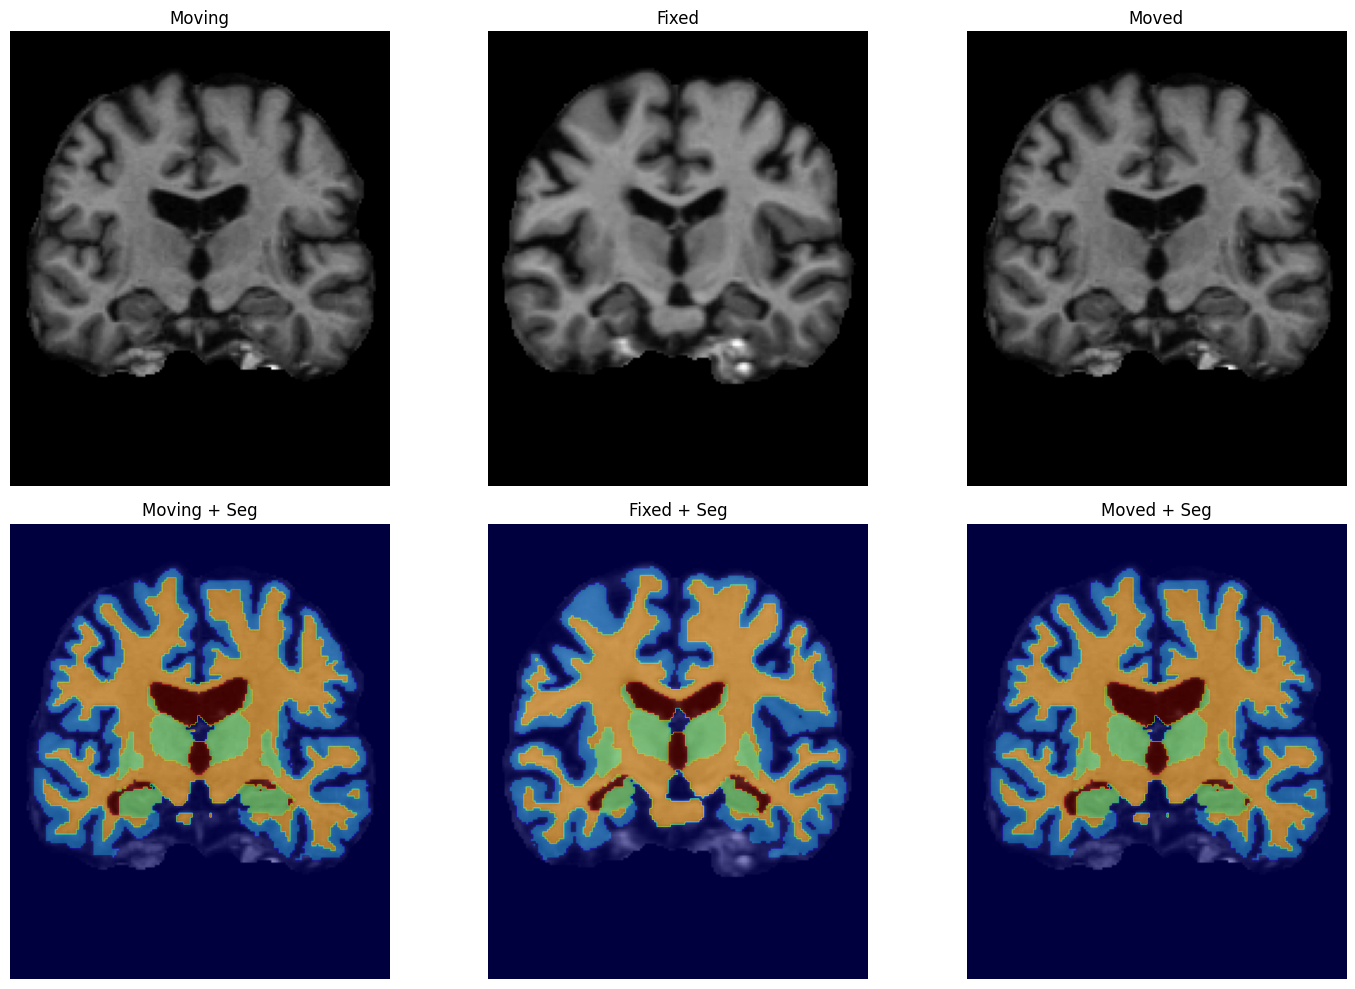

In [15]:
flow_rot_mse = visualize_registration(
    moving_image_file, 
    fixed_image_file, 
    './output/moved_us_mse.nii.gz',
    moving_seg_file=moving_seg_file,
    fixed_seg_file=fixed_seg_file,
    moved_seg_file='./output/warped_seg_us_mse.nii.gz',
    flow_file='./output/warp_us_mse.nii.gz'
)

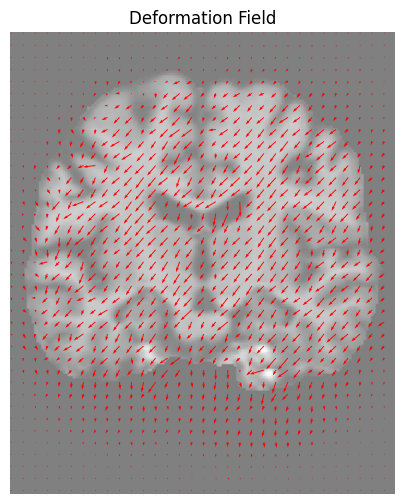

In [16]:
visualize_deformation_field(flow_rot_mse, background=fixed)

In [17]:
dice_scores, mean_dice = compute_dice_score(
    "./output/warped_seg_us_mse.nii.gz", fixed_seg_file, labels=labels, include_zero=False
)

Dice Scores for: ./output/warped_seg_us_mse.nii.gz
  Label 0: Dice = 0.4819
  Label 1: Dice = 0.8010
  Label 2: Dice = 0.6894
  Label 3: Dice = 0.7487
Mean Dice = 0.6803



## Visualize sample output for unsupervised model with NCC loss 

In [18]:
# Command to run the registration script using unsupervised NCC model
!python ../scripts/register.py --moving D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0451_MR1/slice_norm.nii.gz --fixed D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0447_MR1/slice_norm.nii.gz --model ../models_ncc_us_scan/0000.h5 --moved ./output/moved_us_ncc.nii.gz --warp ./output/warp_us_ncc.nii.gz


1/1 [==============================] - 2s 2s/step

1/1 [==============================] - 0s 206ms/step


2025-12-03 03:15:40.260733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2025-12-03 03:15:40.261203: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-12-03 03:15:45.274103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2025-12-03 03:15:45.274315: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-12-03 03:15:45.278356: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: MSI
2025-12-03 03:15:45.278586: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: MSI
2025-12-03 03:15:45.279021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI D

In [19]:
moved_path_ncc = "./output/moved_us_ncc.nii.gz"
summarize_nifti(moved_path_ncc)

--- File: ./output/moved_us_ncc.nii.gz ---
Shape: (160, 192)
Data type: float64
Voxel size (mm): (1.0, 1.0)
Min value: 0.0
Max value: 0.7921420335769653
Mean value: 0.1273061234983709




In [20]:
warp_path_ncc = "./output/warp_us_ncc.nii.gz"
summarize_nifti(warp_path_ncc)

--- File: ./output/warp_us_ncc.nii.gz ---
Shape: (160, 192, 2)
Data type: float64
Voxel size (mm): (1.0, 1.0, 1.0)
Min value: -0.00018577510491013527
Max value: 3.61866332241334e-05
Mean value: -5.111914996356881e-05




In [21]:
warped_seg_ncc = warp_segmentation(moving_seg_file, warp_file="./output/warp_us_ncc.nii.gz", output_file="./output/warped_seg_us_ncc.nii.gz")
summarize_nifti("./output/warped_seg_us_ncc.nii.gz")

1/1 [==============================] - 0s 134ms/step
Warped segmentation saved to: ./output/warped_seg_us_ncc.nii.gz  (shape: (160, 192, 1))
--- File: ./output/warped_seg_us_ncc.nii.gz ---
Shape: (160, 192, 1)
Data type: float64
Voxel size (mm): (1.0, 1.0, 1.0)
Min value: 0.0
Max value: 4.0
Mean value: 0.8318684895833334




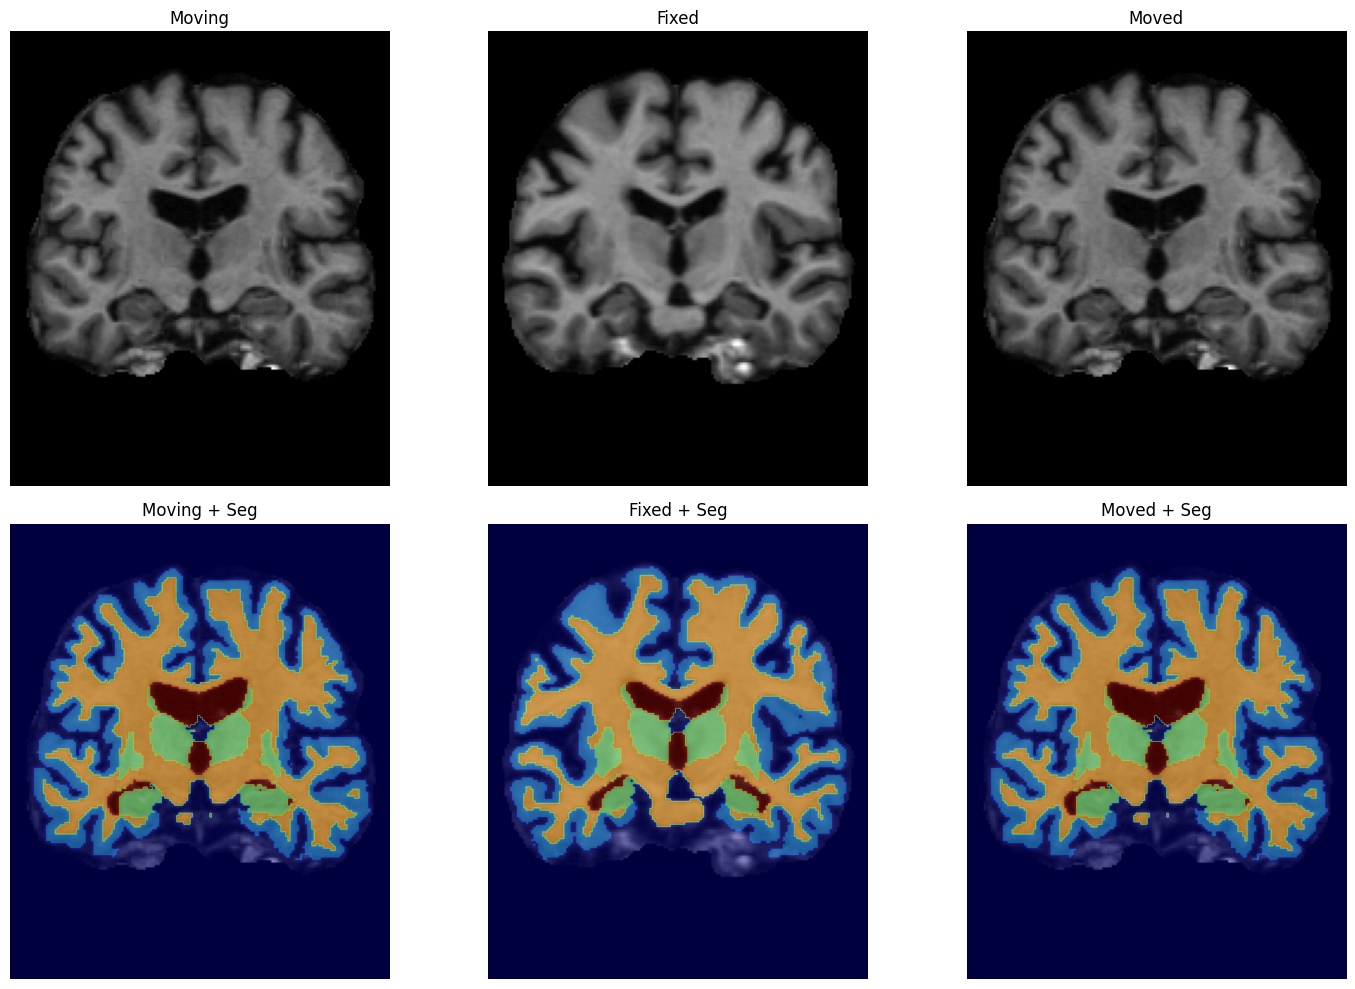

In [22]:
flow_rot_ncc = visualize_registration(
    moving_image_file,
    fixed_image_file,
    './output/moved_us_ncc.nii.gz',
    moving_seg_file=moving_seg_file,
    fixed_seg_file=fixed_seg_file,
    moved_seg_file='./output/warped_seg_us_ncc.nii.gz',
    flow_file='./output/warp_us_ncc.nii.gz'
    )

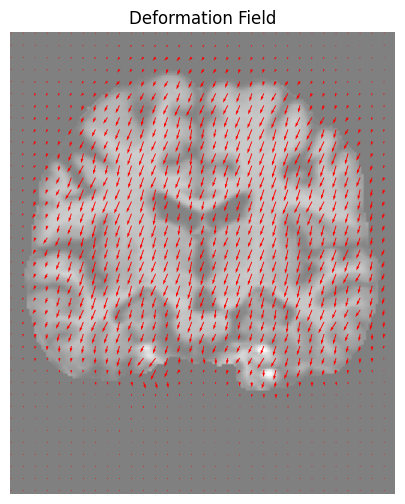

In [23]:
visualize_deformation_field(flow_rot_ncc, background=fixed)

In [24]:
dice_scores_ncc, mean_dice_ncc = compute_dice_score(
    "./output/warped_seg_us_ncc.nii.gz", fixed_seg_file, labels=labels, include_zero=False
)

Dice Scores for: ./output/warped_seg_us_ncc.nii.gz
  Label 0: Dice = 0.4819
  Label 1: Dice = 0.8010
  Label 2: Dice = 0.6894
  Label 3: Dice = 0.7487
Mean Dice = 0.6803



## Visualize sample output for semisupervised model 

In [25]:
# Command to run the registration script using semi-supervised MSE model
!python ../scripts/register_seg.py --moving D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0451_MR1/slice_norm.nii.gz --fixed D:/Computer_vision/voxel_morph/neurite-oasis.2d.v1.0/OASIS_OAS1_0447_MR1/slice_norm.nii.gz --model ../models/0020.h5 --moved ./output/moved_seg.nii.gz --warp ./output/warp_seg.nii.gz --nb-labels 2


1/1 [==============================] - 2s 2s/step

1/1 [==============================] - 0s 210ms/step
Registration done! Warped image saved at ./output/moved_seg.nii.gz
Warp field saved at ./output/warp_seg.nii.gz


2025-12-03 03:15:53.528696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2025-12-03 03:15:53.529357: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-12-03 03:16:00.091806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2025-12-03 03:16:00.092051: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-12-03 03:16:00.096608: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: MSI
2025-12-03 03:16:00.096893: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: MSI
2025-12-03 03:16:00.097363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI D

In [26]:
moved_path_ncc = "./output/moved_seg.nii.gz"
summarize_nifti(moved_path_ncc)

--- File: ./output/moved_seg.nii.gz ---
Shape: (160, 192)
Data type: float64
Voxel size (mm): (1.0, 1.0)
Min value: 0.0
Max value: 0.7367001175880432
Mean value: 0.1283838522022633




In [27]:
warp_path_ncc = "./output/warp_seg.nii.gz"
summarize_nifti(warp_path_ncc)

--- File: ./output/warp_seg.nii.gz ---
Shape: (160, 192, 2)
Data type: float64
Voxel size (mm): (1.0, 1.0, 1.0)
Min value: -4.378183364868164
Max value: 6.059285640716553
Mean value: 0.18379692674281323




In [28]:
warped_seg_ncc = warp_segmentation(moving_seg_file, warp_file="./output/warp_seg.nii.gz", output_file="./output/warped_seg_seg.nii.gz")
summarize_nifti("./output/warped_seg_seg.nii.gz")

1/1 [==============================] - 0s 150ms/step
Warped segmentation saved to: ./output/warped_seg_seg.nii.gz  (shape: (160, 192, 1))
--- File: ./output/warped_seg_seg.nii.gz ---
Shape: (160, 192, 1)
Data type: float64
Voxel size (mm): (1.0, 1.0, 1.0)
Min value: 0.0
Max value: 4.0
Mean value: 0.8185872395833333




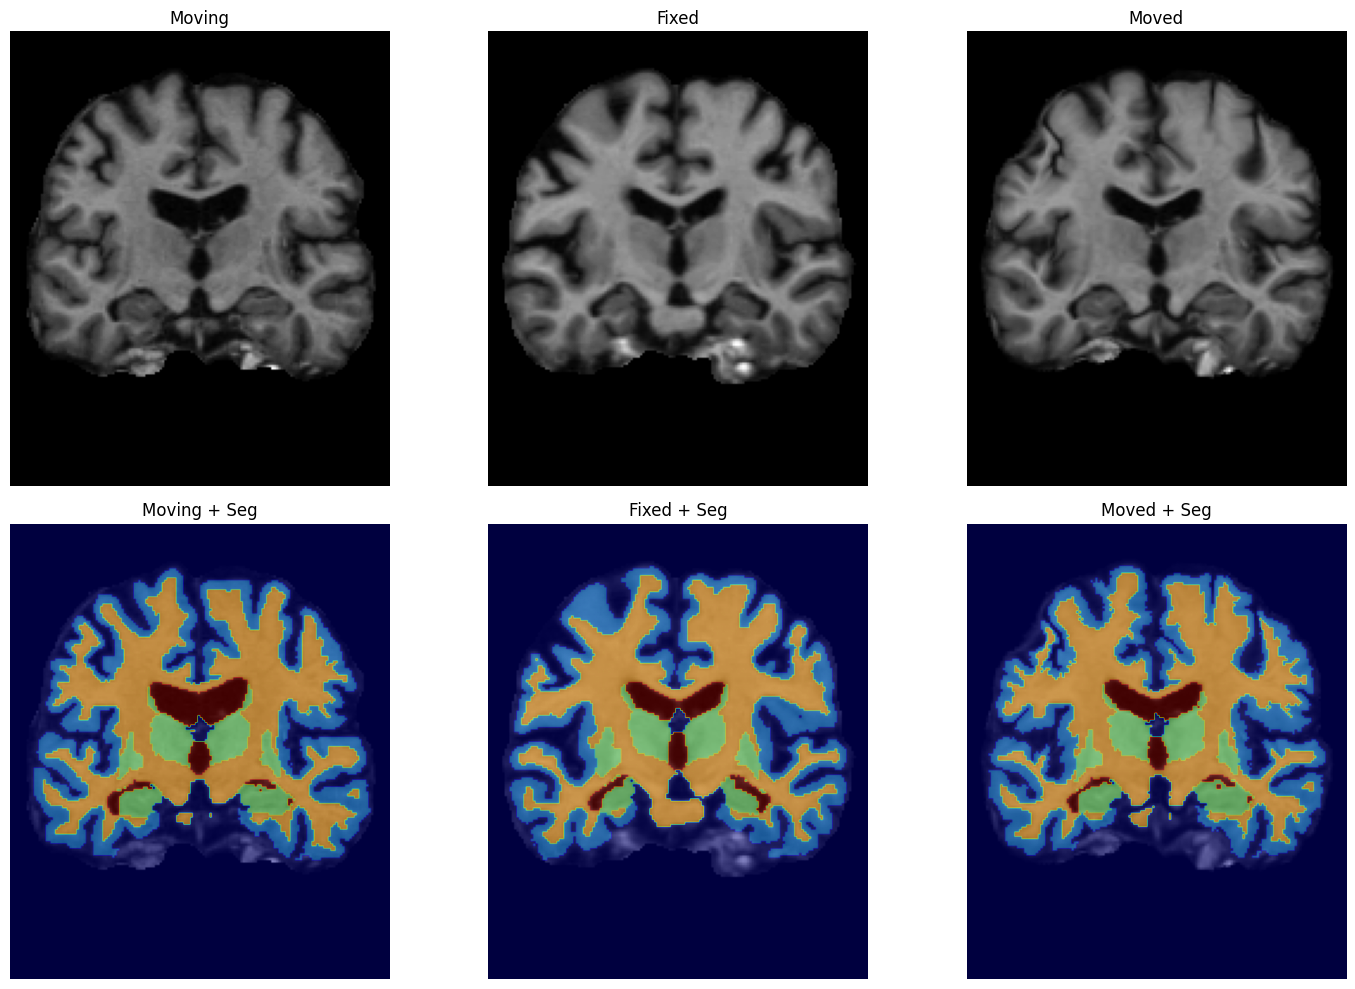

In [29]:
flow_rot_seg = visualize_registration(
    moving_image_file,
    fixed_image_file,
    './output/moved_seg.nii.gz',
    moving_seg_file=moving_seg_file,
    fixed_seg_file=fixed_seg_file,
    moved_seg_file='./output/warped_seg_seg.nii.gz',
    flow_file='./output/warp_seg.nii.gz'
    )

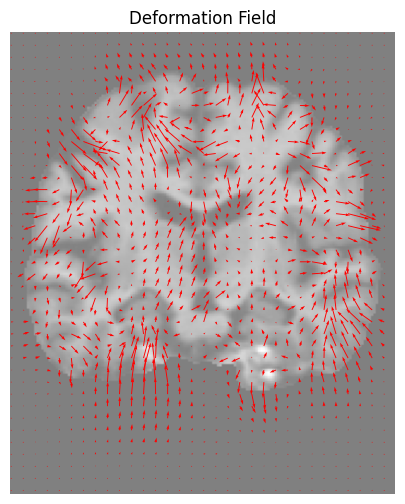

In [30]:
visualize_deformation_field(flow_rot_seg, background=fixed)

In [31]:
dice_scores_seg, mean_dice_seg = compute_dice_score(
    "./output/warped_seg_seg.nii.gz", fixed_seg_file, labels=labels, include_zero=False
)

Dice Scores for: ./output/warped_seg_seg.nii.gz
  Label 0: Dice = 0.6808
  Label 1: Dice = 0.8525
  Label 2: Dice = 0.8179
  Label 3: Dice = 0.8406
Mean Dice = 0.7979



## Compare deformable field 

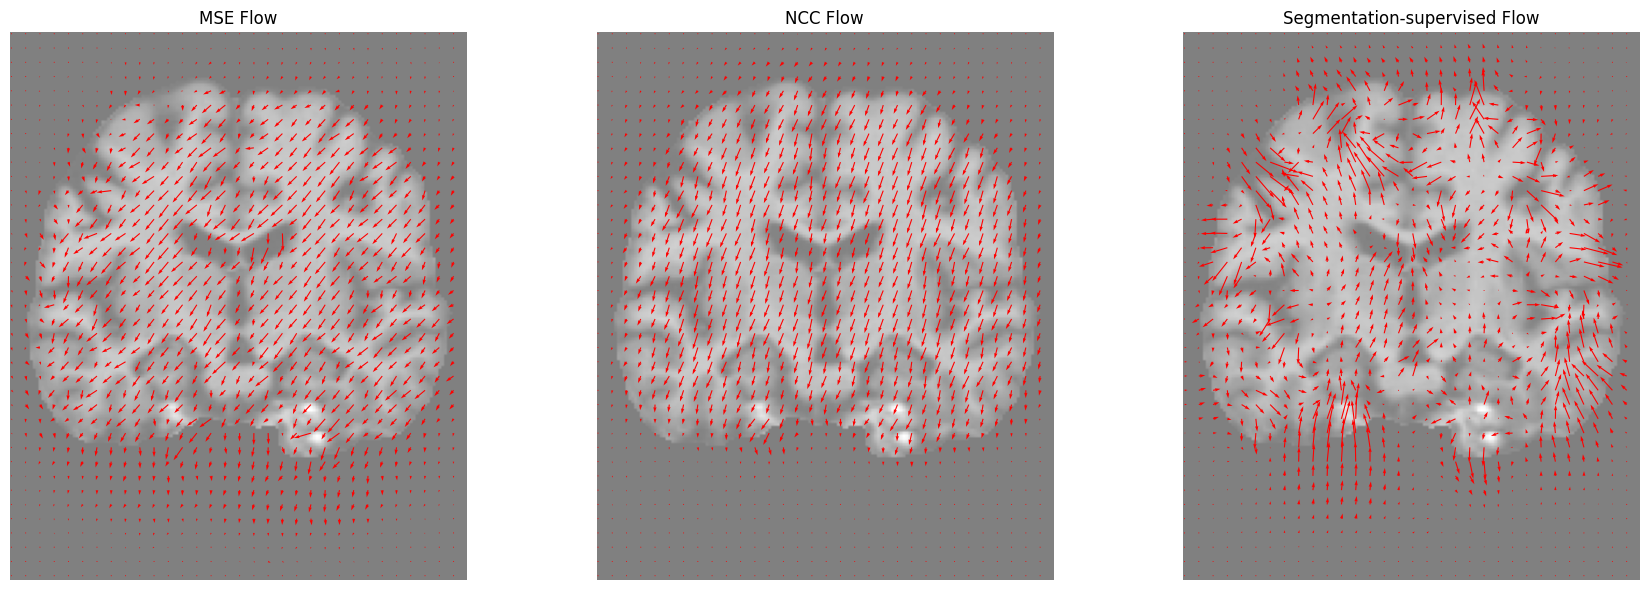

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

visualize_deformation_field(flow_rot_mse, background=fixed, ax=axes[0], title='MSE Flow')
visualize_deformation_field(flow_rot_ncc, background=fixed, ax=axes[1], title='NCC Flow')
visualize_deformation_field(flow_rot_seg, background=fixed, ax=axes[2], title='Segmentation-supervised Flow')

plt.tight_layout()
plt.show()
